In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

In [3]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist
import scipy as sp
import glob
import gc
import pymp
from matplotlib.ticker import FormatStrFormatter
from shutil import copyfile
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from functions.mandyocIO import read_datasets, _extract_interface

%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

In [7]:
#reading dataset information
dataset = [
            'temperature',
            ]# Read data and convert them to xarray.Dataset

#Group 1 CLS - NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT0_rheol19_1Gyr_400ppe_10x10_c_1250_C1' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT100_rheol19_c1250_C1' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT200_rheol19_c1250_C1' #ok

#Group 1 CLS - CRUST 40 km - NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/crust40km/stable_DT200_lit80km_crust40km_HprodAst'
scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/crust40km/stable_DT290_lit80km_crust40km_HprodAst'

#Group 2 CPE - HprodAst
#lit80km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT280_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst' #ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT400_rheol19_c1250_C1_HprodAst' #ok

#lit150km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'#ok

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
    external_media = 'Joao_Macedo'
    model_path = f'/media/joao_macedo/{external_media}{scenario}'

# model_path = machine_path + scenario
dataset = read_datasets(model_path, dataset)

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

z = np.linspace(Lz/1000.0, 0, Nz)
Z = np.linspace(Lz/1000.0, 0, 8001) #zi

# Using parallelism - pymp

CPU times: user 1min 4s, sys: 2.63 s, total: 1min 7s
Wall time: 2min 36s


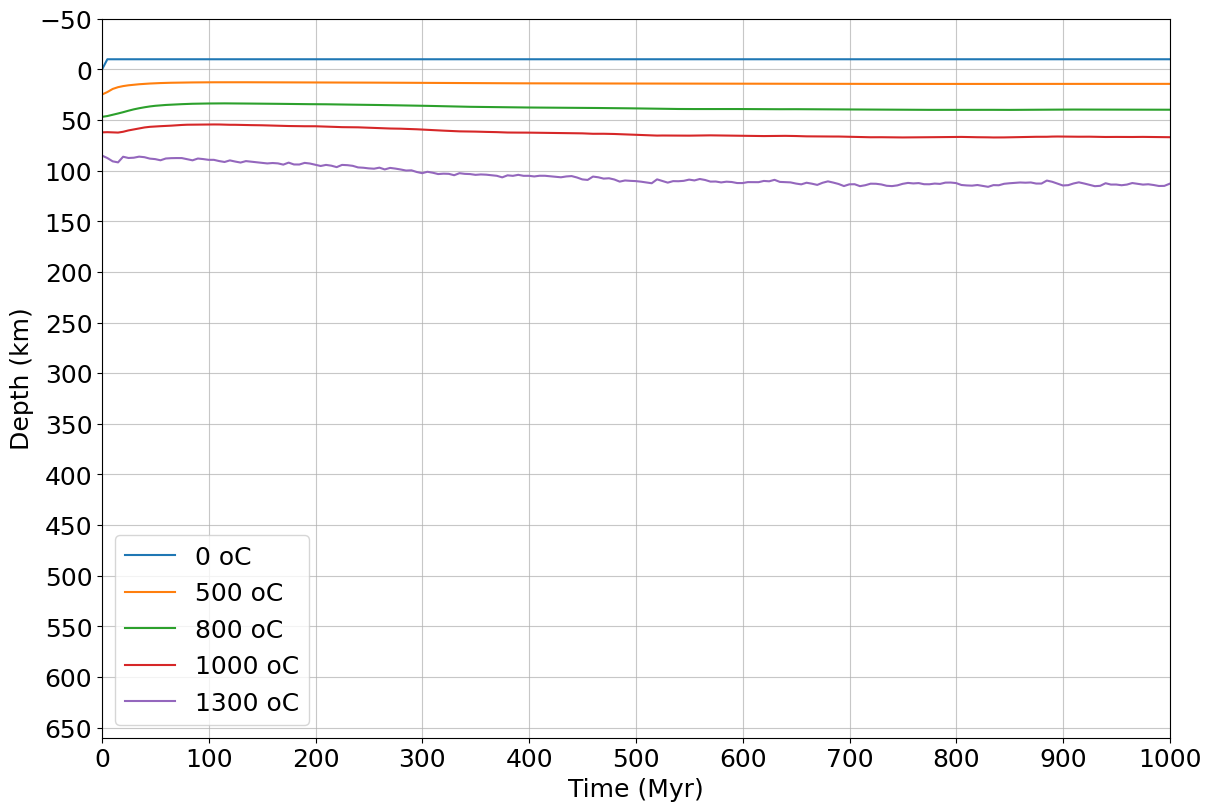

In [8]:
%%time

t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 0
# end = 200
# step = 1

isotherms_list = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700]
# isotherms_list = [800, 1300]

size = (end+step-start)//step* len(isotherms_list)
isotherms_evolution = pymp.shared.dict() #dicionario para preservar a ordem

with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        isoevo = []
        per = np.round(100*(i+1-start)/(end-start), 2)
        text = f"Time: {np.round(float(dataset.time[i]), 2)} Myr; Step: {int(dataset.step[i])}/{int(dataset.step.max())}, ({per:.2f}%)."
        p.print(text, end='\r')

        for k in range(0, len(isotherms_list), 1):
            isotherm_interface = _extract_interface(z, Z, Nx, dataset.temperature[i].T, isotherms_list[k])
            mean_depth = round(np.mean(isotherm_interface), 2)
            isoevo.append(mean_depth)
        
        isotherms_evolution[i] = isoevo #coloca lista inteira na ordem certa para aquele i
#         with p.lock: #sincronizando na mao
#                 isotherms_evolution[i] = isoevo
            
########################################################################################

isotherms_dict = dict(isotherms_evolution) #convertendo pra dicionario normal
evols = [] #empty list to concatenated

for i in sorted(isotherms_dict):#ordenando o dicionario para a ordem do for loop antes de paralelizar
    evols += isotherms_dict[i] #somar listas = concatenar as listas
    
evols = np.asarray(evols)
nrows = len(range(start, end+1, step))
evols = evols.reshape(nrows, len(isotherms_list)).T

data_vars = {}
for isotherm_item, evol in zip(isotherms_list, evols):
    data_vars[f"isot{isotherm_item}"] = evol
    
coords = {'time': dataset.time[start:end:step]}

isot_dataset = xr.Dataset(data_vars = data_vars,
                               coords = {'time': dataset.time[start:end+step:step]},
                               attrs=dict(description='Isotherms evolution', units='degC')
                              )
filename = f"_isotherms_evolution_dataset.nc"
isot_dataset.to_netcdf(f"{model_path}/{filename}")

###############################################################################################################
plot_evolution = True
if(plot_evolution==True):
    #Plot isotherms mean depth evolution
    isotherms_plots = [0, 500, 800, 1000, 1300]
    label_fsize = 18
    plt.rc('xtick', labelsize=label_fsize)
    plt.rc('ytick', labelsize=label_fsize)

    fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)
    h_air = 40.
    for plot in isotherms_plots:
        ax.plot(isot_dataset.time, isot_dataset[f'isot{plot}'] - h_air, label=f'{plot} oC')

    #set plot details
    ax.set_xlim([0,500])
    ax.set_xticks(np.linspace(0,1000,11))
    ax.set_yticks(np.linspace(-50,650,15))
    ax.set_ylim([660, -50])
    ax.grid(':k', alpha=0.7)
    ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
    ax.set_ylabel('Depth (km)', fontsize=label_fsize)
    ax.legend(loc='best', fontsize=18)

    figname = f"{scenario.split('/')[-1]}_isotherms_evolution"
    fig.savefig(f"out/plots/{figname}.pdf", dpi=400)
    fig.savefig(f"out/plots/{figname}.png", dpi=400)

    #This will save inside the experiment directory
    fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
    fig.savefig(f"{model_path}/{figname}.png", dpi=400)

# Sequential
## Can be very slow

In [ ]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 2#5

# start = 0
# end = 10
# step = 1

isotherms_list = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700]
# isotherms_list = [800, 1300]
isotherms_evolution = []

for i in range(start, end+step, step):
    
    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(dataset.time[i]), 2)} Myr; Step: {int(dataset.step[i])}/{int(dataset.step.max())}, ({per:.2f}%)."
    print(text, end='\r')
    
    #extracting isotherms interfaces
    for isotherm_item in isotherms_list:
        isotherm_interface = _extract_interface(z, Z, Nx, dataset.temperature[i].T, isotherm_item)
        mean_depth = round(np.mean(isotherm_interface), 2)
        isotherms_evolution.append(mean_depth)
        
        
isotherms_evolution = np.asarray(isotherms_evolution)
nrows = len(range(start, end+1, step))
isotherms_evolution = isotherms_evolution.reshape(nrows, len(isotherms_list)).T

data_vars = {}
for isotherm_item, isotherm_evolution in zip(isotherms_list, isotherms_evolution):
    data_vars[f"isot{isotherm_item}"] = isotherm_evolution
    
coords = {'time': dataset.time[start:end:step]}

isot_dataset = xr.Dataset(data_vars = data_vars,
                               coords = {'time': dataset.time[start:end+step:step]},
                               attrs=dict(description='Isotherms evolution', units='degC')
                              )
filename = f"_isotherms_evolution_dataset.nc"
isot_dataset.to_netcdf(f"{model_path}/{filename}")

################################################################################################################
plot_evolution = True
if(plot_evolution==True):
    #Plot isotherms mean depth evolution
    isotherms_plots = [0, 500, 800, 1000, 1300]
    label_fsize = 18
    plt.rc('xtick', labelsize=label_fsize)
    plt.rc('ytick', labelsize=label_fsize)

    fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)
    h_air = 40.
    for plot in isotherms_plots:
        ax.plot(isot_dataset.time, isot_dataset[f'isot{plot}'] - h_air, label=f'{plot} oC')

    #set plot details
    ax.set_xlim([0,500])
    ax.set_xticks(np.linspace(0,1000,11))
    ax.set_yticks(np.linspace(-50,650,15))
    ax.set_ylim([660, -50])
    ax.grid(':k', alpha=0.7)
    ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
    ax.set_ylabel('Depth (km)', fontsize=label_fsize)
    ax.legend(loc='best', fontsize=18)

    figname = f"{scenario.split('/')[-1]}_isotherms_evolution"
    fig.savefig(f"out/plots/{figname}.pdf", dpi=400)
    fig.savefig(f"out/plots/{figname}.png", dpi=400)

    # #This will save inside the experiment directory
    fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
    fig.savefig(f"{model_path}/{figname}.png", dpi=400)